In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

In [3]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

### regressor

In [5]:
mm.run.max()

9

In [6]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [7]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [8]:
%%time

# recover additional features (kl/iou)

mmg = mm[mm.segment=='generated']

df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

df_logitlens_iou_expanded = mmg['logitlens_iou'].apply(pd.Series)
df_logitlens_iou_expanded.columns = [f'logitlens_iou{i}' for i in range(df_logitlens_iou_expanded.shape[1])]

# concat with the original
mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                     df_logitlens_kl_expanded,
                     df_logitlens_iou_expanded], axis=1)

CPU times: user 15.6 s, sys: 297 ms, total: 15.9 s
Wall time: 16 s


In [9]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

In [11]:
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')

In [12]:
ds.correct.value_counts()

correct
True     3496
False    1414
Name: count, dtype: int64

In [14]:
ds.columns[1:-3]

Index(['pid', 'true_ent_0', 'true_ent_1', 'true_ent_2', 'true_ent_3',
       'true_ent_4', 'true_ent_5', 'true_ent_6', 'true_ent_7', 'true_ent_8',
       'true_ent_9', 'maxp_0', 'maxp_1', 'maxp_2', 'maxp_3', 'maxp_4',
       'maxp_5', 'maxp_6', 'maxp_7', 'maxp_8', 'maxp_9', 'correct'],
      dtype='object')

In [15]:
# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

In [16]:
y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

In [18]:
X.loc[:,X.nunique()!=1].shape

(769, 20)

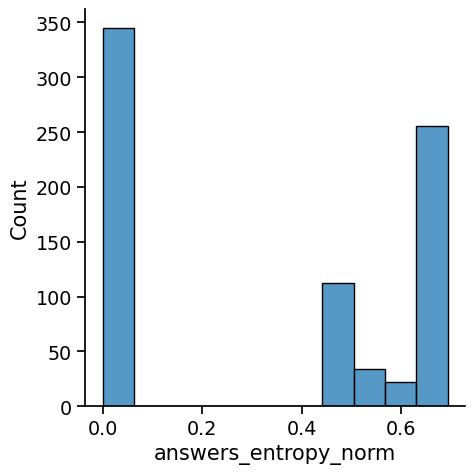

In [19]:
sns.displot(y)

In [20]:
X.isnull().sum().sum() == 0

True

In [21]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [22]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation, entropy

In [23]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 5.11 s, sys: 1.63 s, total: 6.74 s
Wall time: 901 ms


In [24]:
#def jitter(values,j):
#    return values + np.random.normal(j,0.01,values.shape)
#ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(y_res.values, 0.01), hue=correct_mean, size=4)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
#plt.show()

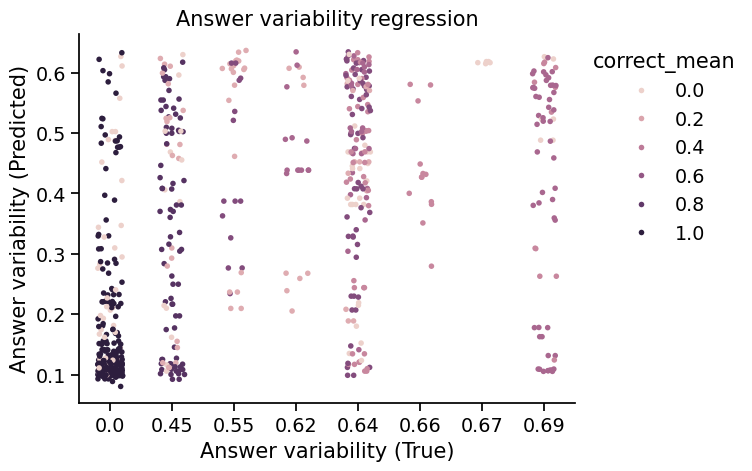

In [25]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [26]:
set(np.round(y_res.values,2).astype(str))

{'0.0', '0.45', '0.55', '0.62', '0.64', '0.66', '0.67', '0.69'}

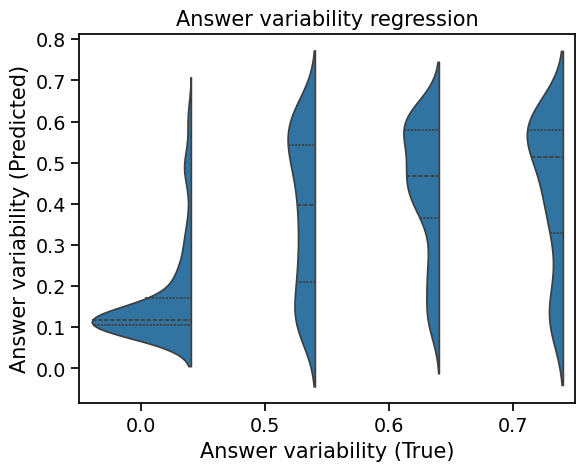

In [27]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,1), 
                    split=True, inner="quart", width=0.8) # , log_scale=(True,False))


plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [29]:
met = assessme(y_res.values, pred)
met

{'mae': 0.18475201615639364,
 'mse': 0.053611393115709144,
 'rmse': 0.23154134213075026,
 'r2': 0.4088363519377023,
 'adj_r2': 0.40806560402627823}

In [30]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

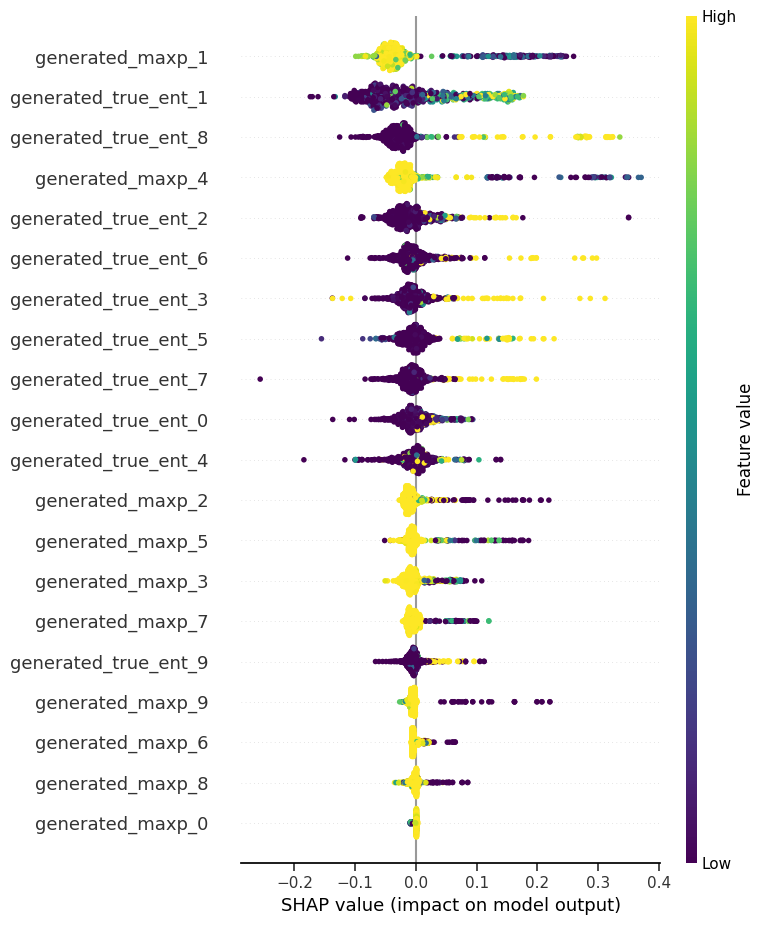

In [31]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [32]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [33]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.41529
generated_true_ent_    0.58471
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

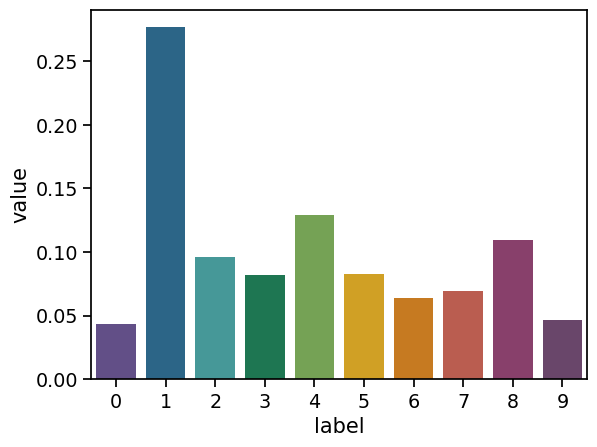

In [34]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

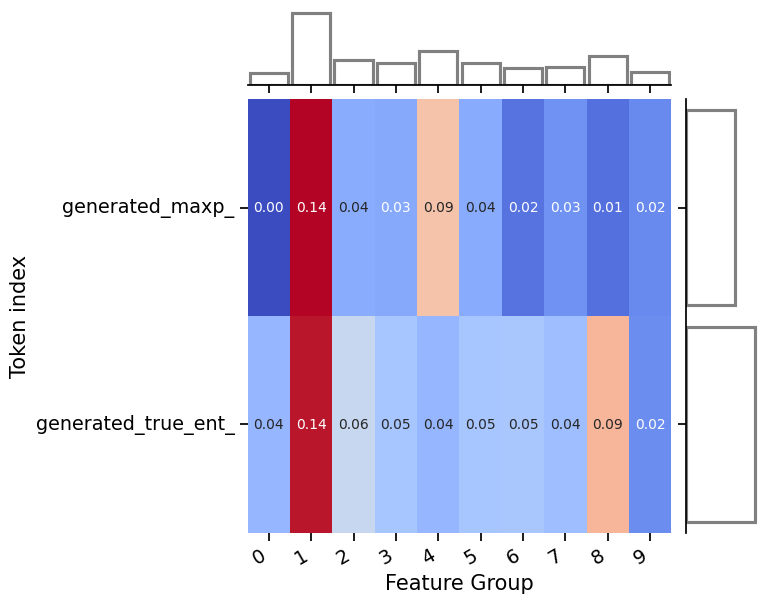

In [35]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### generated + kl/iou

In [115]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [116]:
X_res.shape

(769, 660)

In [117]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 1min 17s, sys: 3.69 s, total: 1min 21s
Wall time: 13.4 s


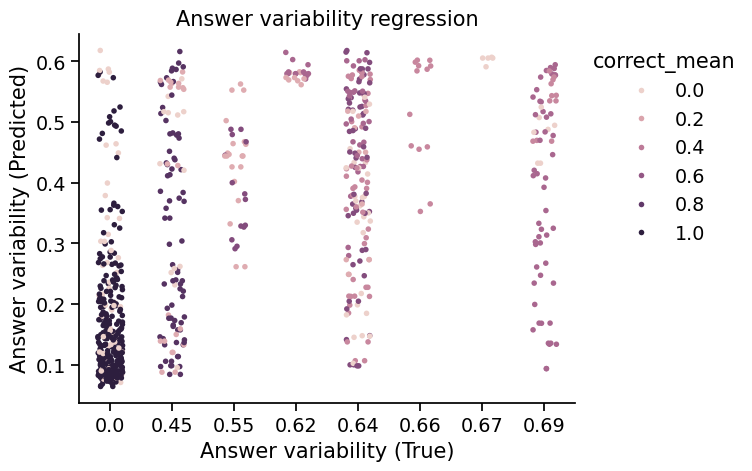

In [118]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [119]:
met_all = assessme(y_res.values, pred)
met_all

{'mae': 0.19168306430486445,
 'mse': 0.05421454256745914,
 'rmse': 0.23284016527965948,
 'r2': 0.4021855262549273,
 'adj_r2': 0.4014061071235778}

In [120]:
%%time

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 11.5 s, sys: 886 ms, total: 12.3 s
Wall time: 2.78 s


In [121]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

grp
generated_logitlens_iou_    0.258689
generated_logitlens_kl_     0.459689
generated_maxp_             0.111718
generated_true_ent_         0.169905
Name: value, dtype: float64

In [122]:
vals

,label,value,label_orig,grp
1,1,0.073891,generated_true_ent_1,generated_true_ent_
11,1,0.047938,generated_maxp_1,generated_maxp_
510,0,0.031249,generated_logitlens_iou17_0,generated_logitlens_iou_
14,4,0.029887,generated_maxp_4,generated_maxp_
8,8,0.029874,generated_true_ent_8,generated_true_ent_
...,...,...,...,...
554,4,0.000000,generated_logitlens_iou21_4,generated_logitlens_iou_
227,7,0.000000,generated_logitlens_kl20_7,generated_logitlens_kl_
550,0,0.000000,generated_logitlens_iou21_0,generated_logitlens_iou_
214,4,0.000000,generated_logitlens_kl19_4,generated_logitlens_kl_


Text(27.44444444444443, 0.5, 'Token index')

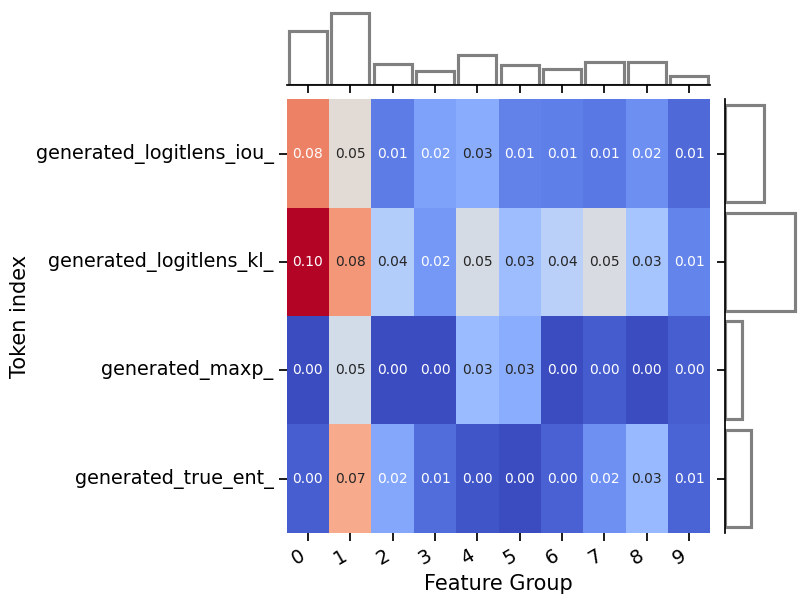

In [123]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [111]:
# beginning of generation
N = 10

selected_features = list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [112]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [113]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

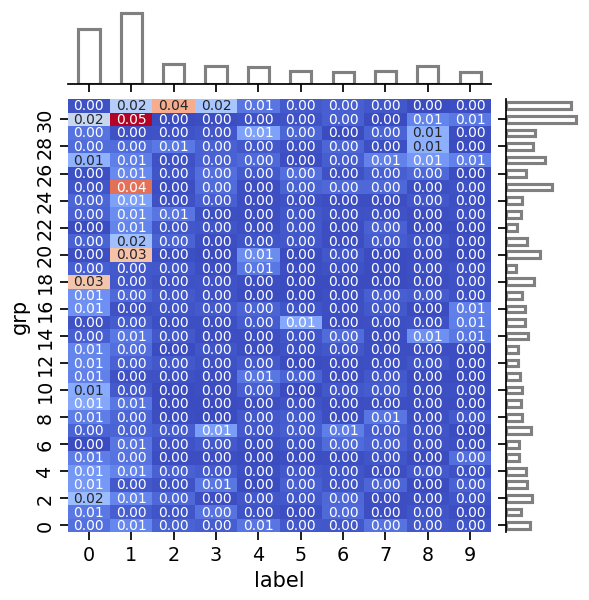

In [114]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

### increasing number of cases

In [155]:
ds.pid.nunique()

666

In [171]:
# test randomness
ds = ds.sample(frac=1)

In [172]:
y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

In [173]:
group_kfold = GroupKFold(n_splits=10)

foldlist = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, pids)):
    foldlist.append(test_index)

In [174]:
%%time

prog = []

# cycle all
for i, idxs in enumerate(foldlist):
    print(i)
    
    test_idx = idxs
    
    # cycle all, skipping i
    train_idx = set()
    c = 0
      
    foldlist_ = [idxs_ for j, idxs_ in enumerate(foldlist) if i != j]
    fold_train_idx = np.concatenate(foldlist_)
    
    # cycle all available pids
    fold_pids = pids.iloc[fold_train_idx]
    
    for pid in tqdm(fold_pids.unique()):
        
        # enlarge dataset one pid at a time
        train_idx = set(train_idx) | set(fold_train_idx[fold_pids == pid]) 
        train_idx = list(train_idx)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)
        xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])

        pred = xgb_model.predict(X.iloc[test_idx])
        
        # always test on out-of-fold data
        met = assessme(y.iloc[test_idx].values, pred)

        prog.append((i, j, c, len(train_idx), met['mae'], met['mse'], met['rmse'], met['r2']))
        c += 1
            

0


100%|█████████████████████████████████████████| 599/599 [00:31<00:00, 19.15it/s]


1


100%|█████████████████████████████████████████| 599/599 [00:32<00:00, 18.35it/s]


2


100%|█████████████████████████████████████████| 599/599 [00:28<00:00, 20.72it/s]


3


100%|█████████████████████████████████████████| 600/600 [00:30<00:00, 19.82it/s]


4


100%|█████████████████████████████████████████| 600/600 [00:31<00:00, 19.30it/s]


5


100%|█████████████████████████████████████████| 600/600 [00:32<00:00, 18.60it/s]


6


100%|█████████████████████████████████████████| 600/600 [00:30<00:00, 19.73it/s]


7


100%|█████████████████████████████████████████| 599/599 [00:29<00:00, 20.59it/s]


8


100%|█████████████████████████████████████████| 599/599 [00:32<00:00, 18.40it/s]


9


100%|█████████████████████████████████████████| 599/599 [00:32<00:00, 18.44it/s]

CPU times: user 37min 2s, sys: 3min 4s, total: 40min 7s
Wall time: 5min 10s


In [175]:
prog_ = pd.DataFrame(prog, columns=['i', 'j', 'c', 'n', 'mae', 'mse', 'rmse', 'r2'])

In [176]:
prog_.shape

(5994, 8)

In [177]:
prog_

,i,j,c,n,mae,mse,rmse,r2
0,0,8,0,2,0.367331,0.232573,0.482258,-1.381917
1,0,8,1,9,0.367331,0.232573,0.482258,-1.381917
2,0,8,2,11,0.348626,0.211643,0.460047,-1.167567
3,0,8,3,13,0.349133,0.208758,0.456900,-1.138016
4,0,8,4,14,0.249305,0.104508,0.323277,-0.070328
...,...,...,...,...,...,...,...,...
5989,9,8,594,935,0.138876,0.033631,0.183388,0.625108
5990,9,8,595,936,0.141875,0.034325,0.185269,0.617378
5991,9,8,596,937,0.141951,0.034935,0.186910,0.610569
5992,9,8,597,938,0.141952,0.035025,0.187151,0.609566


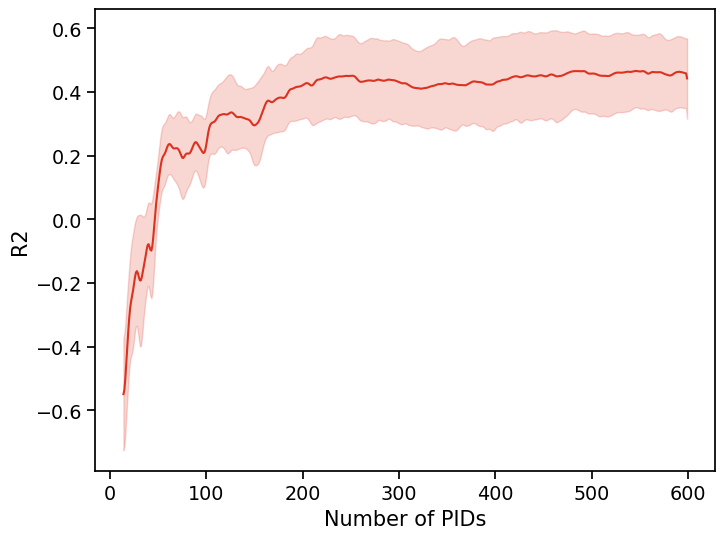

In [187]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=2))

prog_["mae_smooth"] = smooth_data(prog_, "mae", window=15)
prog_["r2_smooth"] = smooth_data(prog_, "r2", window=15)

plt.figure(figsize=(8, 6))
sns.lineplot(prog_, x="c", y="r2_smooth", errorbar="sd", color='#DC3220')
# plt.title("Entropy regression MAE over number of PIDs in training")
plt.xlabel("Number of PIDs")
plt.ylabel("R2")
plt.show()

<Axes: xlabel='c', ylabel='mae'>

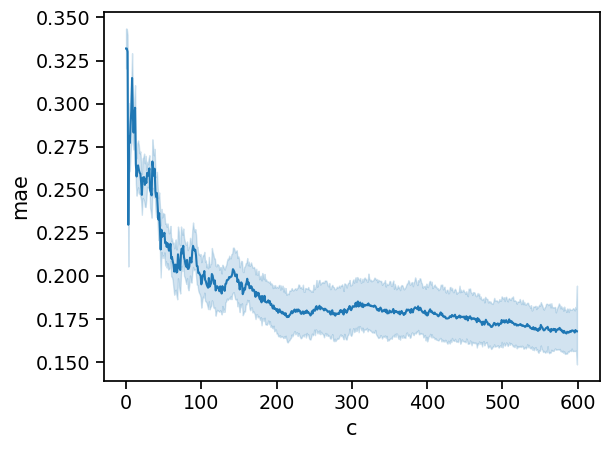

In [178]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

<Axes: xlabel='c', ylabel='mae'>

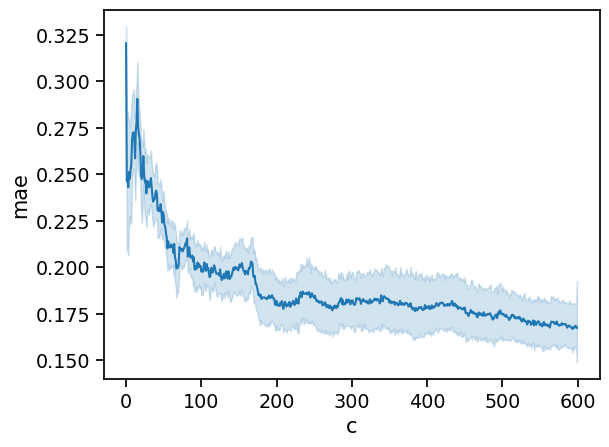

In [166]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

### beginning of generation, accuracy

In [37]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, correct_mean, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 5.98 s, sys: 3.47 s, total: 9.45 s
Wall time: 1.24 s


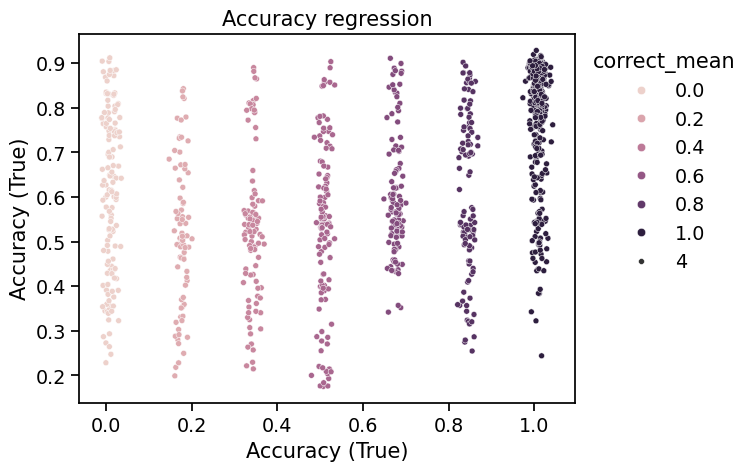

In [48]:
import matplotlib.pyplot as plt

def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)

ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, size=4)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [39]:
met = assessme(correct_mean.values, pred)

 MAE: 0.26447639130258305
 MSE: 0.10927879250254531
 RMSE: 0.3305734298193751
 R²: 0.1880829118677323
 Adjusted R²: 0.18730297230180315


In [40]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, correct_mean)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [41]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [43]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.432009
generated_true_ent    0.567991
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

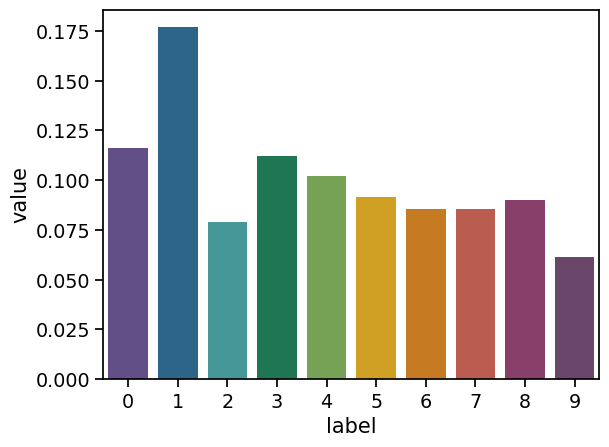

In [42]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### postilla

In [138]:
# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates (include correct as variable)
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla = y_res
X_res.columns = ['postilla_'+col for col in X.columns]

In [140]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 30.8 s, sys: 1.3 s, total: 32.1 s
Wall time: 4.83 s


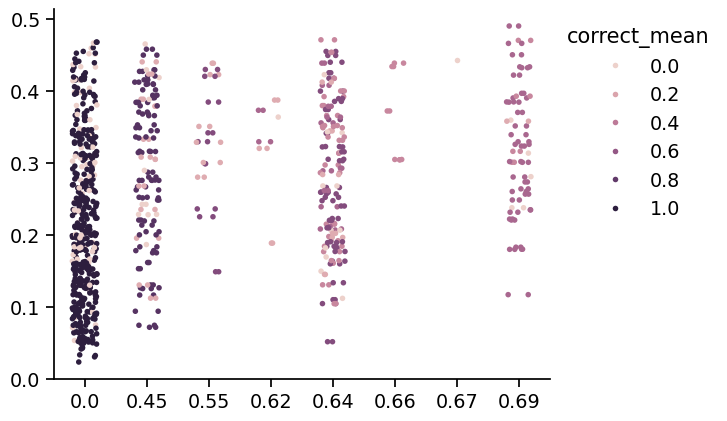

In [141]:
ax = sns.stripplot(y=pred_postilla, x=np.round(y_res_postilla.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()